In [1]:
import time
import copy
import numpy as np
from skimage.filters import gaussian
import cv2 

import matplotlib.pyplot as plt
import pylab as pl

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

from tifffile import imread, imsave
import pickle

%reload_ext autoreload
%autoreload 2

from netsurface2d import NetSurf2d
from netsurface2dt import NetSurf2dt
from data3d import Data3d
import bresenham as bham
import bobsegutils as bsu

from shapely import geometry
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from descartes.patch import PolygonPatch

from scipy.interpolate import griddata

from scipy.stats.stats import pearsonr
from scipy.stats.stats import kendalltau

Populating the interactive namespace from numpy and matplotlib


/Users/prakash/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Loading and preparing data

```stack``` is the original stack as it is loaded from file<br>
```segchannel``` is the membrane channel only (needs to be taken out of loaded stack)<br>
```flowchannel``` is the myosin channel only<br>
```segchannel_smooth``` is the ```segchannel``` after gaussian smoothing<br>
(note: the less the better for the gradientimage)<br>
```gradientimage``` should be used for segmentation if some of the cell boundary (membrane) is barely visible<br>

In [2]:
#filename = '/Users/prakash/anaconda/envs/BobSegExtra/Data/ProjectGoldstein/4MyosinMembraneWholeEmbryo.tif'
#filename = '/Users/prakash/Dropbox/2018-04-13_fromMark/MAX_mNG-mSc_04_MEDIUM_UNCOUPLED.tif'
filename = '/Users/prakash/Dropbox/2018-04-13_fromMark/MAX_mNG-mSc_05_MEDIUM_COUPLED.tif'

stack = imread(filename)
segchannel = stack[:,1,:,:]
flowchannel = stack[:,0,:,:]

sigma = [0.,2,2]
segchannel_smooth = gaussian(segchannel,sigma)
flowchannel_smooth = gaussian(flowchannel,[0.,1,1])

gradientimage = np.minimum(flowchannel_smooth/np.mean(flowchannel_smooth), np.ones_like(flowchannel_smooth))
gradientimage += segchannel_smooth/np.max(segchannel_smooth)
gx = np.gradient(gradientimage, 25, axis=2)
gy = np.gradient(gradientimage, 25, axis=1)
gx = np.abs(gx)
gy = np.abs(gy)
gradientimage = gx+gy                  # add x and y gradients
gradientimage /= np.max(gradientimage) # normalizes such that largest value is 1.0
gradientimage **= .5                   # emphasizes smaller gradient values
gradientimage = gaussian(gradientimage,sigma)

T = len(segchannel)  # number of time-points

print('Shape of stack:', stack.shape)
print('Shape of flow channel:', flowchannel.shape)

Shape of stack: (61, 2, 545, 833)
Shape of flow channel: (61, 545, 833)


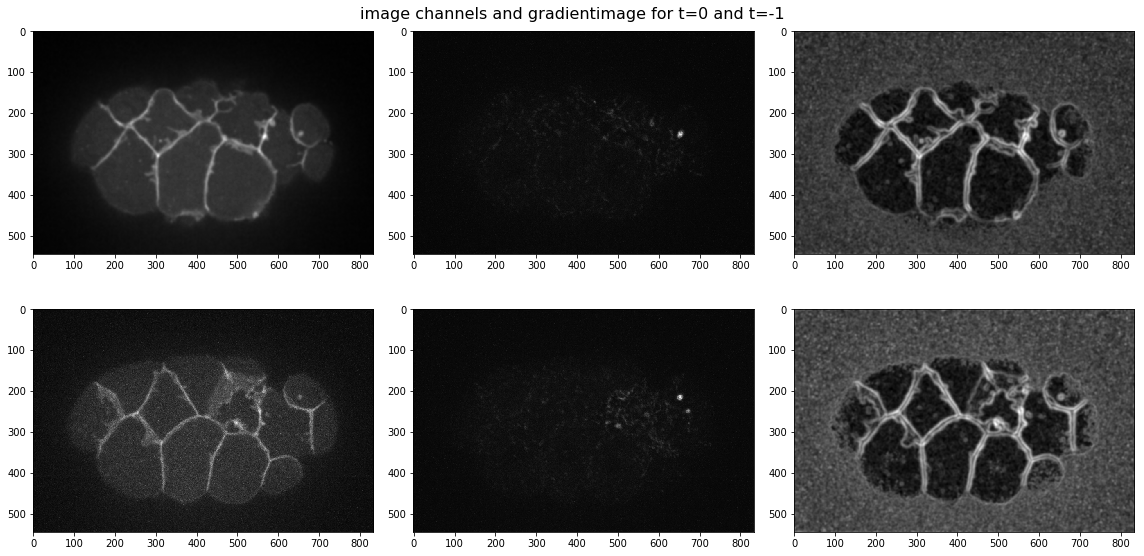

In [3]:
pylab.rcParams['figure.figsize'] = (16, 8)
fig = plt.figure()
fig.suptitle('image channels and gradientimage for t=0 and t=-1', fontsize=16)
ax = fig.add_subplot(231)
ax.imshow(segchannel_smooth[0], plt.get_cmap('gray'))
ax = fig.add_subplot(232)
ax.imshow(flowchannel[0], plt.get_cmap('gray'))
ax = fig.add_subplot(233)
ax.imshow(gradientimage[0], plt.get_cmap('gray'))
ax = fig.add_subplot(234)
ax.imshow(segchannel[-1], plt.get_cmap('gray'))
ax = fig.add_subplot(235)
ax.imshow(flowchannel[-1], plt.get_cmap('gray'))
ax = fig.add_subplot(236)
ax.imshow(gradientimage[-1], plt.get_cmap('gray'))
fig.tight_layout()

# Cell segmentation

In [4]:
# defining min and max radius for cell segmentation
max_rs = ((segchannel[0].shape[1] / 6),
          (segchannel[0].shape[1] / 6))

min_rs = (10,10)
print (min_rs, max_rs)

(10, 10) (138.83333333333334, 138.83333333333334)


In [5]:
data = Data3d( gradientimage, pixelsize=(1.,1.), silent=False )
data.set_seg_params(num_columns=72,K=100,max_delta_k=4)
objects = []

In [6]:
cell_Ea = data.init_object("Ea")
objects.append(cell_Ea)
data.add_object_at( cell_Ea, min_rs, max_rs, frame=0, seed=(520,225), segment_it=True )
data.track(cell_Ea, seed_frame=0, target_frames=range(1,len(data.images)), recenter_iterations=1)

Added appearance for "Ea" in frame 0 with seed coordinates [ 520.  225.]
      Optimum energy:  28.36896162907729
      Nodes in/out:  3207 3993
      Area:  13678.0
Added appearance for "Ea" in frame 1 with seed coordinates [ 520.  225.]
      Optimum energy:  28.500836909039368
      Nodes in/out:  3307 3893
      Area:  14467.0
    Updated center to [ 519.20833333  216.04166667]
Added appearance for "Ea" in frame 2 with seed coordinates [ 519.  216.]
      Optimum energy:  27.916485001131047
      Nodes in/out:  3361 3839
      Area:  14553.5
    Updated center to [ 517.84722222  210.81944444]
Added appearance for "Ea" in frame 3 with seed coordinates [ 518.  211.]
      Optimum energy:  26.92860475058851
      Nodes in/out:  3396 3804
      Area:  14738.0
    Updated center to [ 517.38888889  208.88888889]
Added appearance for "Ea" in frame 4 with seed coordinates [ 517.  209.]
      Optimum energy:  25.673381786065335
      Nodes in/out:  3398 3802
      Area:  14768.5
    Updated

      Optimum energy:  37.17636433575996
      Nodes in/out:  2706 4494
      Area:  10095.5
    Updated center to [ 520.23611111  232.04166667]
Added appearance for "Ea" in frame 39 with seed coordinates [ 520.  232.]
      Optimum energy:  35.982659658274
      Nodes in/out:  2615 4585
      Area:  9507.0
    Updated center to [ 518.66666667  233.56944444]
Added appearance for "Ea" in frame 40 with seed coordinates [ 519.  234.]
      Optimum energy:  38.408551333434175
      Nodes in/out:  2433 4767
      Area:  8296.5
    Updated center to [ 516.79166667  234.19444444]
Added appearance for "Ea" in frame 41 with seed coordinates [ 517.  234.]
      Optimum energy:  37.427851263621896
      Nodes in/out:  2532 4668
      Area:  8849.0
    Updated center to [ 515.69444444  234.27777778]
Added appearance for "Ea" in frame 42 with seed coordinates [ 516.  234.]
      Optimum energy:  37.01001692077858
      Nodes in/out:  2503 4697
      Area:  8769.0
    Updated center to [ 515.2222222

In [7]:
cell_Ep = data.init_object("Ep")
objects.append(cell_Ep)
data.add_object_at( cell_Ep, min_rs, max_rs, frame=0, seed=(620,275), segment_it=True )
data.track(cell_Ep, seed_frame=0, target_frames=range(1,len(data.images)), recenter_iterations=1)

Added appearance for "Ep" in frame 0 with seed coordinates [ 620.  275.]
      Optimum energy:  28.71703194579776
      Nodes in/out:  2389 4811
      Area:  8718.5
Added appearance for "Ep" in frame 1 with seed coordinates [ 620.  275.]
      Optimum energy:  30.196884729510096
      Nodes in/out:  2513 4687
      Area:  9359.5
    Updated center to [ 612.26388889  276.43055556]
Added appearance for "Ep" in frame 2 with seed coordinates [ 612.  276.]
      Optimum energy:  29.555919750418344
      Nodes in/out:  2690 4510
      Area:  9958.5
    Updated center to [ 610.09722222  274.55555556]
Added appearance for "Ep" in frame 3 with seed coordinates [ 610.  275.]
      Optimum energy:  29.361384683424607
      Nodes in/out:  2636 4564
      Area:  9574.0
    Updated center to [ 609.63888889  273.30555556]
Added appearance for "Ep" in frame 4 with seed coordinates [ 610.  273.]
      Optimum energy:  28.86685684358893
      Nodes in/out:  2660 4540
      Area:  9730.0
    Updated cent

Added appearance for "Ep" in frame 39 with seed coordinates [ 607.  292.]
      Optimum energy:  33.06970974853693
      Nodes in/out:  3431 3769
      Area:  15451.0
    Updated center to [ 606.95833333  291.72222222]
Added appearance for "Ep" in frame 40 with seed coordinates [ 607.  292.]
      Optimum energy:  32.76043623169521
      Nodes in/out:  3315 3885
      Area:  14605.0
    Updated center to [ 606.73611111  289.81944444]
Added appearance for "Ep" in frame 41 with seed coordinates [ 607.  290.]
      Optimum energy:  34.35656771186844
      Nodes in/out:  3591 3609
      Area:  16866.0
    Updated center to [ 608.5         291.98611111]
Added appearance for "Ep" in frame 42 with seed coordinates [ 608.  292.]
      Optimum energy:  32.89775213183331
      Nodes in/out:  3472 3728
      Area:  15890.5
    Updated center to [ 607.72222222  295.88888889]
Added appearance for "Ep" in frame 43 with seed coordinates [ 608.  296.]
      Optimum energy:  30.08855988439953
      Nod

In [8]:
surface_coords_Ea = data.segment2dt( cell_Ea, max_radial_delta=2 )

Results for frame 0:
      Optimum energy:  1993.7698125053084
      Area:  14776.5
Results for frame 1:
      Optimum energy:  1993.7698125053084
      Area:  14703.0
Results for frame 2:
      Optimum energy:  1993.7698125053084
      Area:  14579.5
Results for frame 3:
      Optimum energy:  1993.7698125053084
      Area:  14563.0
Results for frame 4:
      Optimum energy:  1993.7698125053084
      Area:  14561.5
Results for frame 5:
      Optimum energy:  1993.7698125053084
      Area:  14433.5
Results for frame 6:
      Optimum energy:  1993.7698125053084
      Area:  14181.5
Results for frame 7:
      Optimum energy:  1993.7698125053084
      Area:  14044.0
Results for frame 8:
      Optimum energy:  1993.7698125053084
      Area:  13892.5
Results for frame 9:
      Optimum energy:  1993.7698125053084
      Area:  13603.0
Results for frame 10:
      Optimum energy:  1993.7698125053084
      Area:  13600.5
Results for frame 11:
      Optimum energy:  1993.7698125053084
      Area:

In [9]:
surface_coords_Ep = data.segment2dt( cell_Ep, max_radial_delta=2 )

Results for frame 0:
      Optimum energy:  1898.321013392633
      Area:  10128.0
Results for frame 1:
      Optimum energy:  1898.321013392633
      Area:  10037.5
Results for frame 2:
      Optimum energy:  1898.321013392633
      Area:  10049.0
Results for frame 3:
      Optimum energy:  1898.321013392633
      Area:  9896.5
Results for frame 4:
      Optimum energy:  1898.321013392633
      Area:  9824.0
Results for frame 5:
      Optimum energy:  1898.321013392633
      Area:  9876.5
Results for frame 6:
      Optimum energy:  1898.321013392633
      Area:  10027.0
Results for frame 7:
      Optimum energy:  1898.321013392633
      Area:  10067.5
Results for frame 8:
      Optimum energy:  1898.321013392633
      Area:  10112.5
Results for frame 9:
      Optimum energy:  1898.321013392633
      Area:  10376.5
Results for frame 10:
      Optimum energy:  1898.321013392633
      Area:  10454.0
Results for frame 11:
      Optimum energy:  1898.321013392633
      Area:  10727.5
Resul

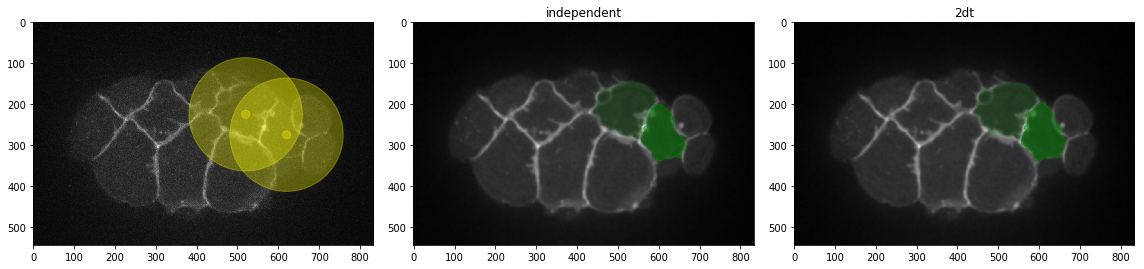

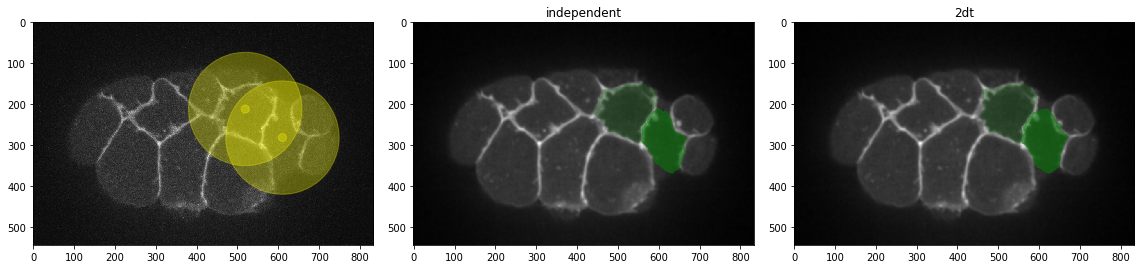

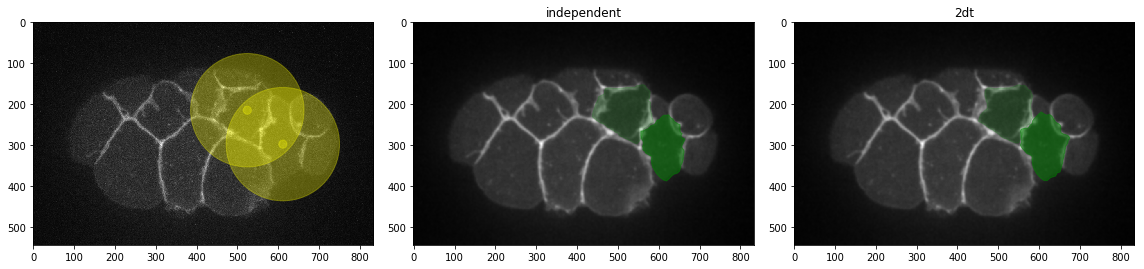

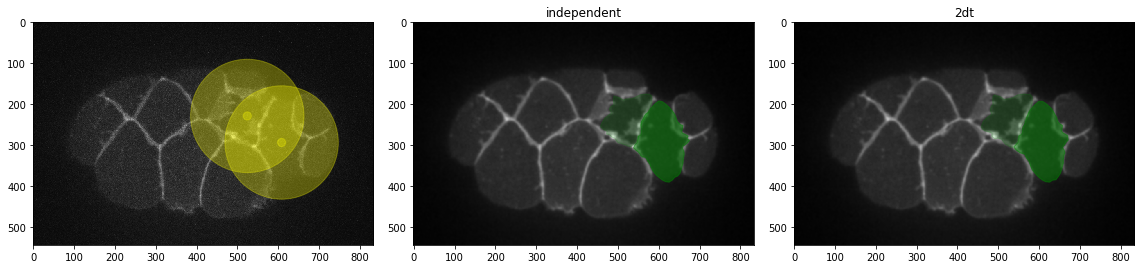

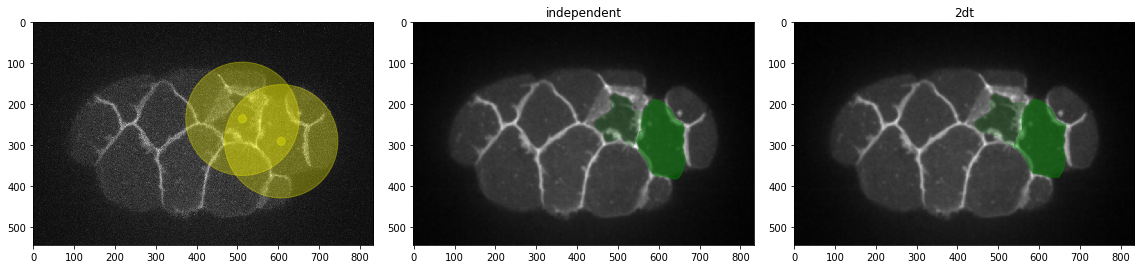

In [10]:
pylab.rcParams['figure.figsize'] = (16, 10)
for frame in range(1,len(data.images),int(len(data.images)/5)):
    fig = plt.figure()
    ax = plt.subplot(131)
    data.plot_minmax( frame, ax, segchannel )
    ax = plt.subplot(132)
    ax.set_title('independent')
    data.plot_result( frame, ax, segchannel_smooth )    
    ax = plt.subplot(133)
    ax.set_title('2dt')
    data.plot_2dt_result( frame, ax, segchannel_smooth )
    fig.tight_layout()

# Flow computation

In [11]:
flows = bsu.compute_flow( flowchannel )
flow_x, flow_y = bsu.split_flow_components( flows )

............................................................. ...done!


In [12]:
avg_flow_x = bsu.flow_average(flow_x, 5)
avg_flow_y = bsu.flow_average(flow_y, 5)
total_avg_flow_x = np.average(flow_x, axis=0)
total_avg_flow_y = np.average(flow_y, axis=0)

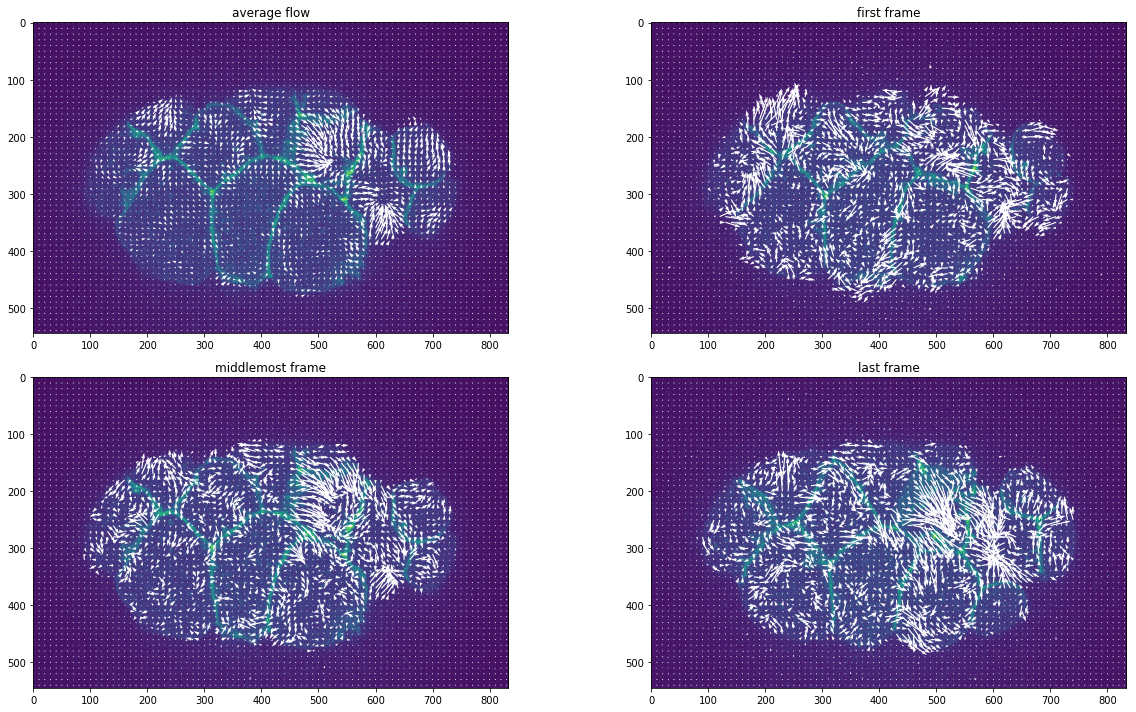

In [13]:
pylab.rcParams['figure.figsize'] = (18, 10)
fig = plt.figure()

y,x = np.mgrid[0:shape(segchannel)[1]:1, 0:shape(segchannel)[2]:1]
skip = (slice(None, None, 10), slice(None, None, 10))

ax = plt.subplot(221)
ax.set_title('average flow')
ax.imshow(segchannel[int(len(flowchannel)/2)])#, plt.get_cmap('gray'))
ax.quiver(x[skip],y[skip],total_avg_flow_x[skip],-total_avg_flow_y[skip], color='w', scale=50)

ax = plt.subplot(222)
ax.set_title('first frame')
ax.imshow(segchannel[0])#, plt.get_cmap('gray'))
ax.quiver(x[skip],y[skip],avg_flow_x[0][skip],-avg_flow_y[0][skip], color='w', scale=50)

ax = plt.subplot(223)
ax.set_title('middlemost frame')
ax.imshow(segchannel[int(len(flowchannel)/2)])#, plt.get_cmap('gray'))
ax.quiver(x[skip],y[skip],avg_flow_x[int(len(flowchannel)/2)][skip],-avg_flow_y[int(len(flowchannel)/2)][skip], color='w', scale=50)

ax = plt.subplot(224)
ax.set_title('last frame')
ax.imshow(segchannel[-1])#, plt.get_cmap('gray'))
ax.quiver(x[skip],y[skip],avg_flow_x[-1][skip],-avg_flow_y[-1][skip], color='w', scale=50)

fig.tight_layout()
fig.savefig('test.pdf',dpi=300)

# Flow data crunching...

In [14]:
annulus_outer_factor = .85
annulus_inner_factor = .6

In [15]:
membrane_polygones_per_object = []
annulus_outer_polygones_per_object = []
annulus_middle_polygones_per_object = []
annulus_inner_polygones_per_object = []
for obj in objects:
    membrane_polygones = []
    annulus_outer_polygones = []
    annulus_middle_polygones = []
    annulus_inner_polygones = []
    for t in range(T):
        membrane_polygones.append( data.netsurf2dt[obj].get_polygone_points(t,1.0) )
        annulus_outer_polygones.append( data.netsurf2dt[obj].get_polygone_points(t,annulus_outer_factor) )
        annulus_middle_polygones.append( data.netsurf2dt[obj].get_polygone_points(t,(annulus_outer_factor+annulus_inner_factor)/2) )
        annulus_inner_polygones.append( data.netsurf2dt[obj].get_polygone_points(t,annulus_inner_factor) )
    membrane_polygones_per_object.append(membrane_polygones)
    annulus_outer_polygones_per_object.append(annulus_outer_polygones)
    annulus_middle_polygones_per_object.append(annulus_middle_polygones)
    annulus_inner_polygones_per_object.append(annulus_inner_polygones)

In [16]:
print((membrane_polygones_per_object[0][0]))

[(585, 225), (580, 230), (574, 234), (570, 238), (570, 243), (569, 248), (568, 253), (568, 258), (565, 262), (562, 267), (559, 272), (557, 278), (555, 286), (551, 293), (544, 292), (537, 289), (530, 285), (525, 283), (520, 283), (514, 283), (509, 281), (504, 283), (497, 286), (492, 284), (487, 281), (483, 276), (477, 276), (474, 270), (469, 267), (464, 263), (463, 257), (465, 250), (462, 246), (455, 242), (450, 237), (444, 231), (439, 225), (443, 218), (444, 211), (446, 205), (453, 200), (453, 194), (453, 186), (452, 177), (460, 174), (468, 173), (476, 172), (483, 173), (491, 175), (493, 168), (497, 163), (502, 159), (508, 160), (513, 154), (520, 155), (526, 154), (532, 154), (538, 154), (545, 153), (552, 155), (559, 157), (565, 159), (571, 163), (573, 171), (578, 175), (584, 180), (588, 185), (594, 190), (594, 197), (591, 205), (588, 212), (587, 219)]


In [17]:
def get_annulus_bresenham_lines(inner_polygone, outer_polygone):
    annulus_bresenham_lines = []
    for i in range(len(inner_polygone)):
        points = bham.bresenhamline( np.array([inner_polygone[i]]),np.array([outer_polygone[i]]) )
        annulus_bresenham_lines.append(points)
    return annulus_bresenham_lines

In [18]:
annulus_bresenham_lines_per_frame_per_object = []
for obj in objects:
    annulus_bresenham_lines_per_frame = []
    for t in range(T):
        annulus_bresenham_lines = get_annulus_bresenham_lines( annulus_inner_polygones_per_object[obj][t], annulus_outer_polygones_per_object[obj][t] )
        annulus_bresenham_lines_per_frame.append( annulus_bresenham_lines )
    annulus_bresenham_lines_per_frame_per_object.append( annulus_bresenham_lines_per_frame )

### compute membrane movement vectors

In [19]:
membrane_movement_vectors_per_frame_per_object = []
for obj in objects:
    membrane_movement_vectors_per_frame = []
    for t in range(T-1):
        membrane_movement_vectors = []
        poly_t1 = membrane_polygones_per_object[obj][t]
        poly_t2 = membrane_polygones_per_object[obj][t+1]
        for i in range(len(poly_t1)):
            p1 = [poly_t1[i][0] , poly_t1[i][1]]
            p2 = [poly_t2[i][0] , poly_t2[i][1]]
            membrane_movement_vectors.append( [p2[0]-p1[0] , p2[1]-p1[1]] )
        membrane_movement_vectors_per_frame.append( membrane_movement_vectors )
    membrane_movement_vectors_per_frame_per_object.append( membrane_movement_vectors_per_frame )

### compute averaged flow vectors

In [20]:
annulus_avg_flow_vectors_per_frame_per_object = []
for obj in objects:
    annulus_avg_flow_vectors_per_frame = []
    for t in range(T):
        annulus_avg_flow_vectors = []
        lines = annulus_bresenham_lines_per_frame_per_object[obj][t]
        for l, line in enumerate(lines):
            sum_x = 0.0
            sum_y = 0.0
            for point in line:
                sum_x += avg_flow_x[t,point[1],point[0]]
                sum_y += avg_flow_y[t,point[1],point[0]]
            avg_x = sum_x / len(line)
            avg_y = sum_y / len(line)
            annulus_avg_flow_vectors.append([avg_x,avg_y])
        annulus_avg_flow_vectors_per_frame.append(annulus_avg_flow_vectors)
    annulus_avg_flow_vectors_per_frame_per_object.append( annulus_avg_flow_vectors_per_frame )

### compute projected vector lengths

In [21]:
column_vectors = data.netsurfs[0][0].col_vectors # they are normalized to length 1

In [22]:
projected_avg_flows_per_frame_per_object = []
projected_mem_vecs_per_frame_per_object = []
for obj in objects:
    projected_avg_flows_per_frame = []
    projected_mem_vecs_per_frame = []
    for t in range(T-1):
        projected_avg_flows = []
        projected_mem_vecs = []
        for i in range(len(column_vectors)):
            projected_avg_flows.append( bsu.get_projected_length(annulus_avg_flow_vectors_per_frame_per_object[obj][t][i] ,column_vectors[i]) )
            projected_mem_vecs.append( bsu.get_projected_length(membrane_movement_vectors_per_frame_per_object[obj][t][i] ,column_vectors[i]) )
        projected_avg_flows_per_frame.append( projected_avg_flows )
        projected_mem_vecs_per_frame.append( projected_mem_vecs )
    projected_avg_flows_per_frame_per_object.append( projected_avg_flows_per_frame )
    projected_mem_vecs_per_frame_per_object.append( projected_mem_vecs_per_frame )

### compute frame averages and correlations for lineplots

In [23]:
avg_membrane_contraction_per_frame_per_object = []
avg_center_flow_per_frame_per_object = []
correlation_per_frame_per_object = []
for obj in objects:
    avg_membrane_contraction_per_frame = []
    avg_center_flow_per_frame = []
    correlation_per_frame = []
    for t in range(T-1):
        memveclengths=projected_mem_vecs_per_frame_per_object[obj][t]
        flowveclengths=projected_avg_flows_per_frame_per_object[obj][t]
        
        avg_membrane_contraction_per_frame.append( np.mean(memveclengths) )
        avg_center_flow_per_frame.append( np.mean( flowveclengths) )
        correlation_per_frame.append( pearsonr(memveclengths, flowveclengths)[0] )
        
    avg_membrane_contraction_per_frame_per_object.append( avg_membrane_contraction_per_frame )
    avg_center_flow_per_frame_per_object.append( avg_center_flow_per_frame )
    correlation_per_frame_per_object.append( correlation_per_frame )

### initialize imaginary myosins

In [24]:
initialization_time = 0

In [25]:
initial_myo_pos_per_object = []
for obj in objects:
    initial_myo_pos_list = []
    for i in range(len(column_vectors)):
        initial_myo_pos_list.append(annulus_bresenham_lines_per_frame_per_object[obj][initialization_time][i])
    initial_myo_pos = [item for sublist in initial_myo_pos_list for item in sublist]
    initial_myo_pos_per_object.append(initial_myo_pos)
# initial_myo_pos_per_object = []
# for obj in objects:
#     initial_myo_pos_per_object.append(annulus_outer_polygones_per_object[obj][initialization_time])

### Tracking imaginary myosins over time

In [26]:
position_imaginary_myosins_per_frame_per_object = []
for obj in objects:
    position_imaginary_myosins_per_frame = []
    temporary_list = initial_myo_pos_per_object[obj]
    for t in range(initialization_time, T, 1):
        position_imaginary_myosin = []
        for myosin_count in range(len(temporary_list)):
            new_myosin_position = bsu.update_pos(temporary_list[myosin_count],t, avg_flow_x, avg_flow_y)
            position_imaginary_myosin.append(new_myosin_position)
            temporary_list[myosin_count] = new_myosin_position
        position_imaginary_myosins_per_frame.append(position_imaginary_myosin)
        
    position_imaginary_myosins_per_frame_per_object.append(position_imaginary_myosins_per_frame)

### Number crunching for plots

In [27]:
cumulative_myosin_dist_per_frame_per_object = []
for obj in objects:
    cumulative_myosin_dist_per_frame = []
    for frame in range(0,len(segchannel)-initialization_time-1,1):
        myosin_dist_from_center = 0

        for i in range(len(initial_myo_pos_per_object[obj])):
            dist2 = bsu.euclid_dist(position_imaginary_myosins_per_frame_per_object[obj][frame][i], data.object_seedpoints[obj][frame+1])
            myosin_dist_from_center = dist2 + myosin_dist_from_center

        cumulative_myosin_dist_per_frame.append(myosin_dist_from_center)   
    cumulative_myosin_dist_per_frame_per_object.append(cumulative_myosin_dist_per_frame)

In [28]:
cumulative_membrane_dist_per_frame_per_object = []
for obj in objects:
    cumulative_membrane_dist_per_frame = []
    for frame in range(1,len(segchannel)-initialization_time,1):
        membrane_dist_from_center = 0
        for j in range(len(column_vectors)):
            dist1 = bsu.euclid_dist(membrane_polygones_per_object[obj][frame][j], data.object_seedpoints[obj][frame])
            membrane_dist_from_center = membrane_dist_from_center+dist1
        cumulative_membrane_dist_per_frame.append(membrane_dist_from_center)
    cumulative_membrane_dist_per_frame_per_object.append(cumulative_membrane_dist_per_frame)

In [29]:
#Number crunching for plots
flow_movement_factor_list_per_object = []
membrane_movement_factor_list_per_object = []
for obj in objects:
    flow_movement_factor_list = []
    membrane_movement_factor_list =[]
    for i in range(len(cumulative_myosin_dist_per_frame_per_object[obj])-1):
        flow_movement_factor = cumulative_myosin_dist_per_frame_per_object[obj][i+1]/cumulative_myosin_dist_per_frame_per_object[obj][i]
        flow_movement_factor_list.append(flow_movement_factor)
        membrane_movement_factor = cumulative_membrane_dist_per_frame_per_object[obj][i+1]/cumulative_membrane_dist_per_frame_per_object[obj][i]
        membrane_movement_factor_list.append(membrane_movement_factor)
    flow_movement_factor_list_per_object.append(flow_movement_factor_list)
    membrane_movement_factor_list_per_object.append(membrane_movement_factor_list)

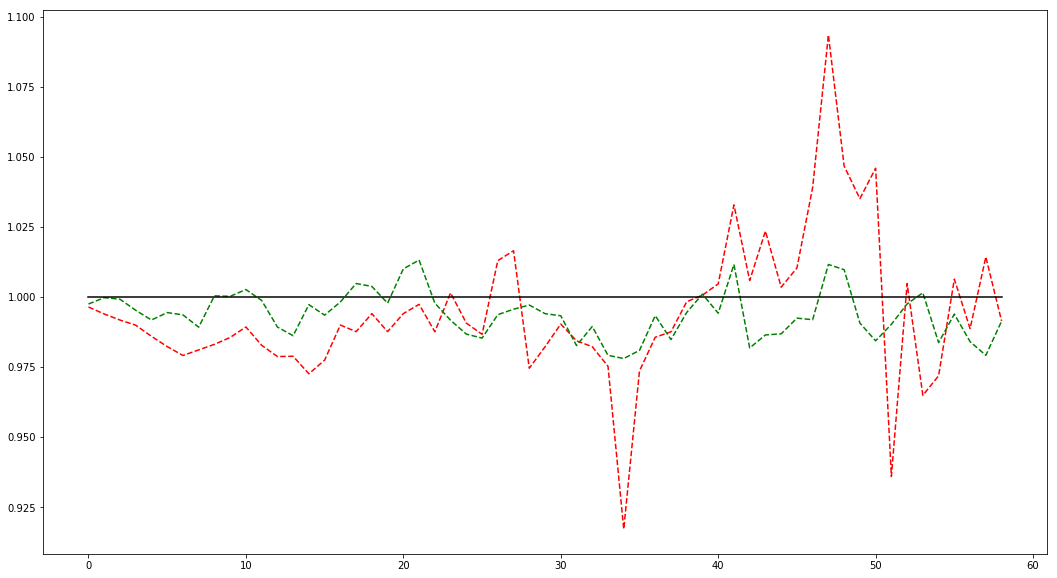

In [30]:
#Plotting flow ratio and membrane ratio computed above
t = np.arange(initialization_time, len(membrane_movement_factor_list_per_object[0]), 1.)
plt.plot(t, flow_movement_factor_list_per_object[0], 'r--',t, membrane_movement_factor_list_per_object[0], 'g--')
plt.plot(t, np.ones_like(t),'k-')
plt.show()

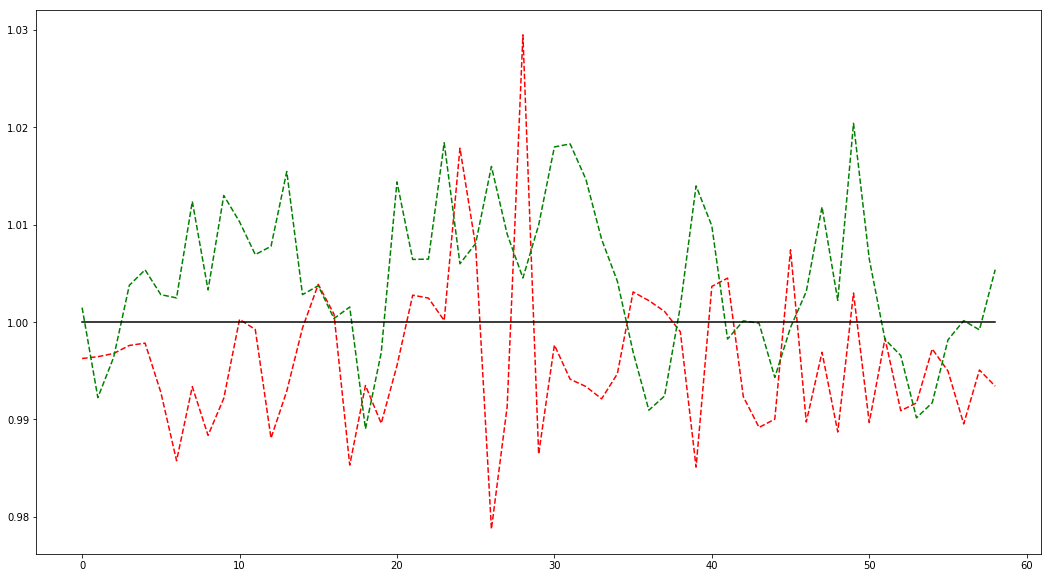

In [31]:
#Plotting flow ratio and membrane ratio computed above
t = np.arange(initialization_time, len(membrane_movement_factor_list_per_object[1]), 1.)
plt.plot(t, flow_movement_factor_list_per_object[1], 'r--',t, membrane_movement_factor_list_per_object[1], 'g--')
plt.plot(t, np.ones_like(t),'k-')
plt.show()

In [32]:
flow_movement_factor_list_per_object[0] = [list(x) for x in flow_movement_factor_list_per_object[0]]
flattened_flow_movement_factor_list0 = [val for sublist in flow_movement_factor_list_per_object[0] for val in sublist]

In [33]:
flow_movement_factor_list_per_object[1] = [list(x) for x in flow_movement_factor_list_per_object[1]]
flattened_flow_movement_factor_list1 = [val for sublist in flow_movement_factor_list_per_object[1] for val in sublist]

In [42]:
corr0 = []
length = 25
for start in range(0,len(flow_movement_factor_list_per_object[0])-length,1):
    c0,p0 = pearsonr(flattened_flow_movement_factor_list0[start:start+length], membrane_movement_factor_list_per_object[0][start:start+length])
    print('start: ', start, '; ','till ',start+length, c0, p0)
    corr0.append(c0)

start:  0 ;  till  25 0.437830355846 0.0286016328765
start:  1 ;  till  26 0.42735262347 0.0331068582766
start:  2 ;  till  27 0.273198079889 0.186381360339
start:  3 ;  till  28 0.206285752026 0.322507699131
start:  4 ;  till  29 0.195600758945 0.348743914913
start:  5 ;  till  30 0.198907878252 0.340491903273
start:  6 ;  till  31 0.187960857599 0.368255139933
start:  7 ;  till  32 0.191820153243 0.35832114816
start:  8 ;  till  33 0.18757958906 0.369245139258
start:  9 ;  till  34 0.280920480043 0.173744309863
start:  10 ;  till  35 0.471402141709 0.0173706701279
start:  11 ;  till  36 0.485134939422 0.0139675434456
start:  12 ;  till  37 0.491530457234 0.012581482538
start:  13 ;  till  38 0.473510573404 0.0168080532325
start:  14 ;  till  39 0.467502772316 0.0184517307224
start:  15 ;  till  40 0.50253489176 0.0104627877679
start:  16 ;  till  41 0.498643803888 0.0111752362137
start:  17 ;  till  42 0.580786079364 0.00233322493317
start:  18 ;  till  43 0.538635833301 0.0054706634

In [44]:
corr1 = []
length = 25
for start in range(0,len(flow_movement_factor_list_per_object[1])-length,1):
    c1,p1 = pearsonr(flattened_flow_movement_factor_list1[start:start+length], membrane_movement_factor_list_per_object[1][start:start+length])
    print('start: ', start, '; ','till ',start+length, c1, p1)
    corr1.append(c1)

start:  0 ;  till  25 0.120607371984 0.565787429579
start:  1 ;  till  26 0.142783295205 0.495954924517
start:  2 ;  till  27 -0.00943825882211 0.964285764198
start:  3 ;  till  28 -0.0141048967915 0.946647786438
start:  4 ;  till  29 -0.0492164234353 0.815276210001
start:  5 ;  till  30 -0.0681588850723 0.746147206706
start:  6 ;  till  31 -0.069601806866 0.740951554313
start:  7 ;  till  32 -0.118817838032 0.57160846108
start:  8 ;  till  33 -0.122426731205 0.559896766358
start:  9 ;  till  34 -0.150419924966 0.472945844317
start:  10 ;  till  35 -0.130699288828 0.533468381157
start:  11 ;  till  36 -0.16073534056 0.442759002741
start:  12 ;  till  37 -0.182204187173 0.383366562603
start:  13 ;  till  38 -0.189004925731 0.365552021752
start:  14 ;  till  39 -0.170001816141 0.416544405136
start:  15 ;  till  40 -0.209824227828 0.31409164401
start:  16 ;  till  41 -0.192889057797 0.355597830527
start:  17 ;  till  42 -0.206205471864 0.322700217825
start:  18 ;  till  43 -0.221645380963

Text(0,0.5,'correlation')

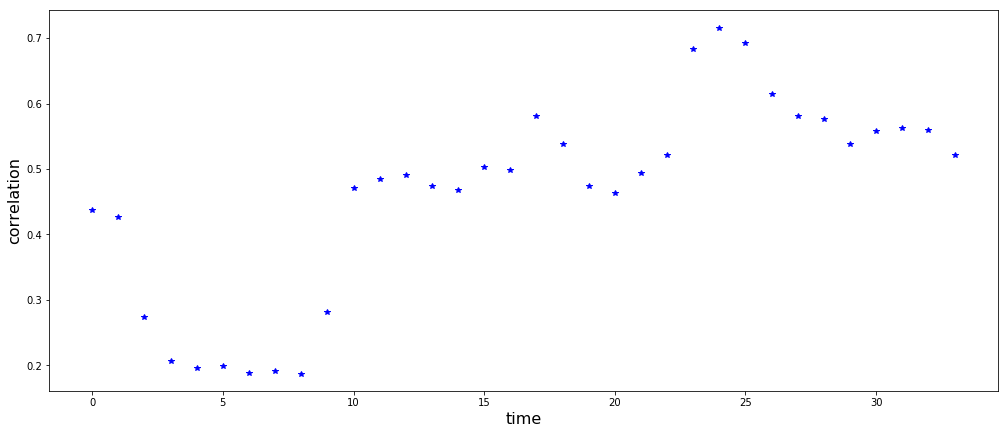

In [45]:
pyplot.plot(corr0, 'b*')
plt.xlabel('time', fontsize = 16)
plt.ylabel('correlation', fontsize = 16)

Text(0,0.5,'correlation')

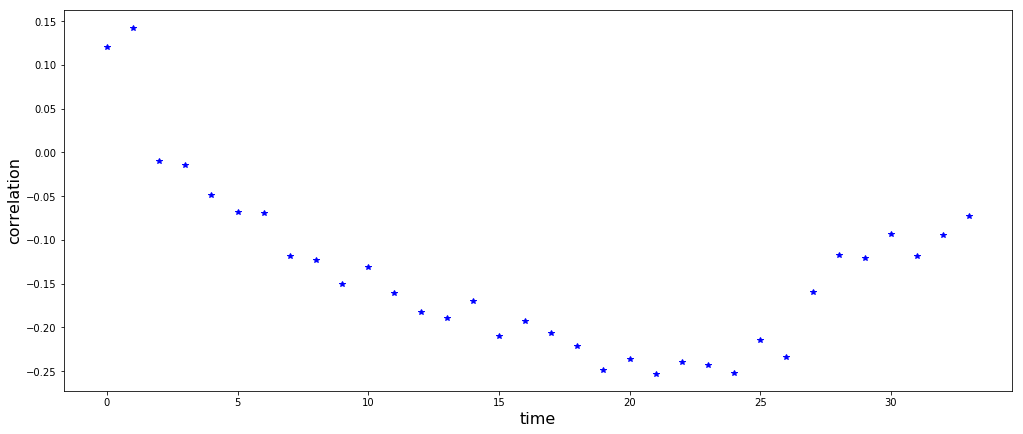

In [46]:
pyplot.plot(corr1, 'b*')
plt.xlabel('time', fontsize = 16)
plt.ylabel('correlation', fontsize = 16)

In [38]:
def plot_coords(ax, poly, c, style='.-', alpha=.5):
    x, y = poly.xy
    ax.plot(x, y, style, color=c, alpha=alpha, zorder=1)

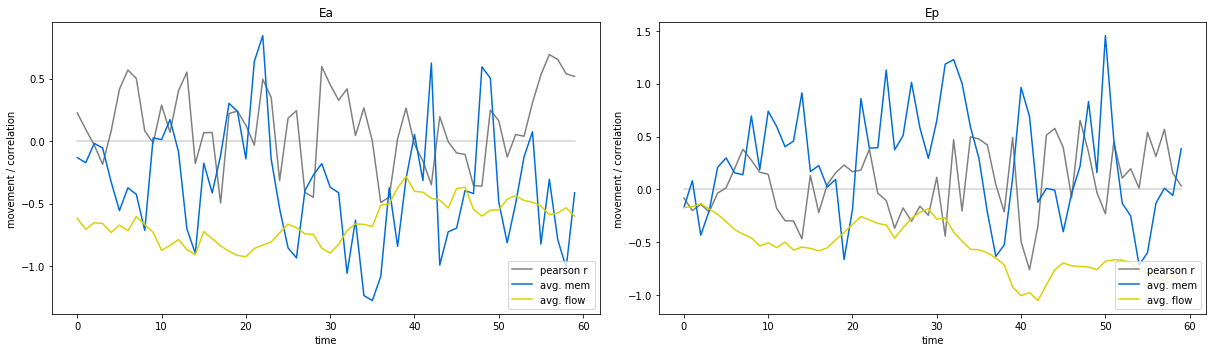

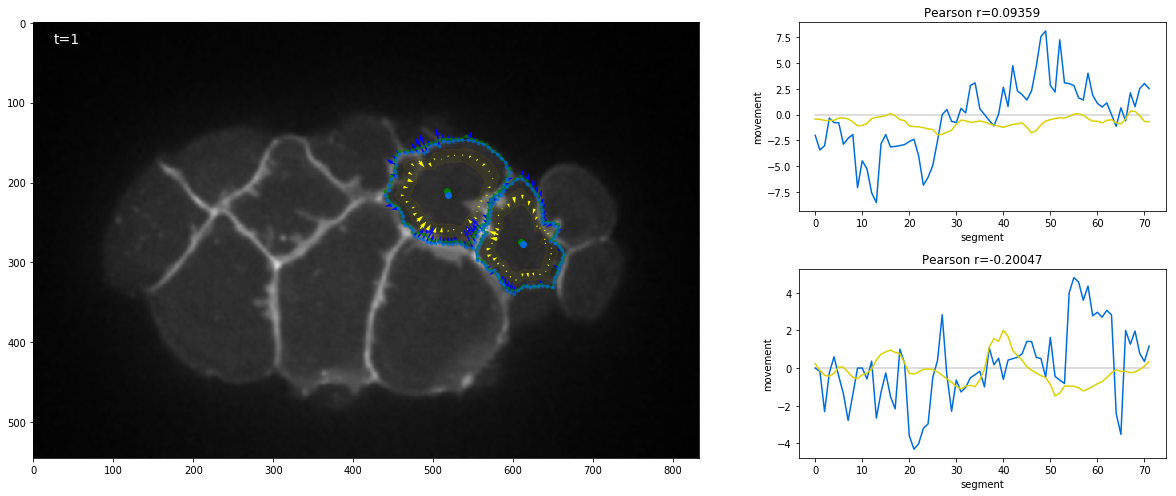

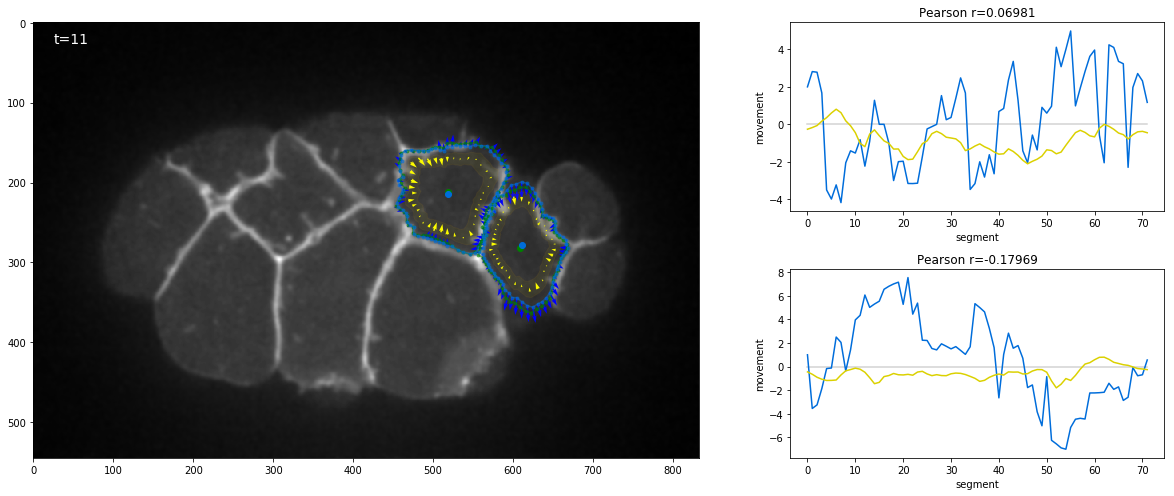

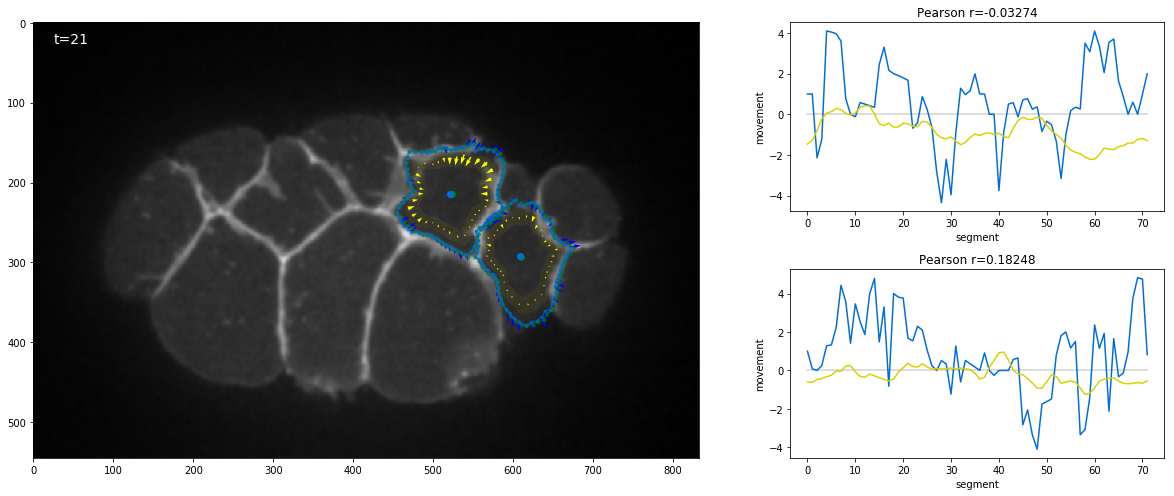

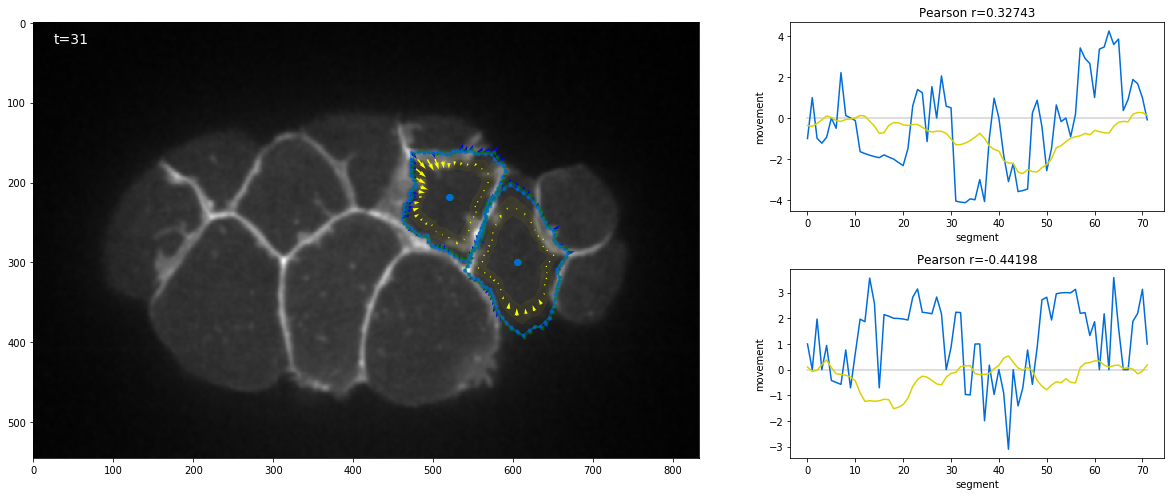

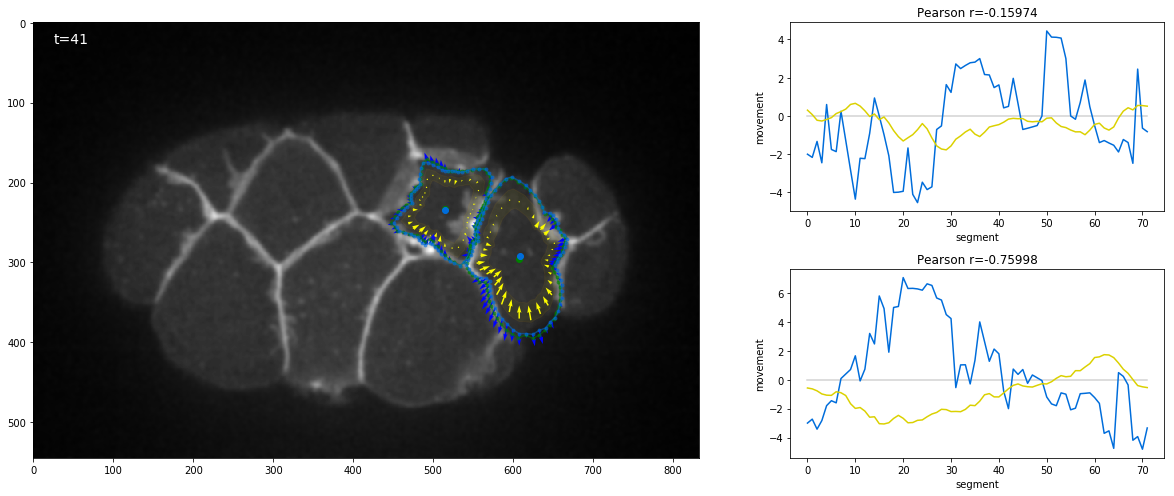

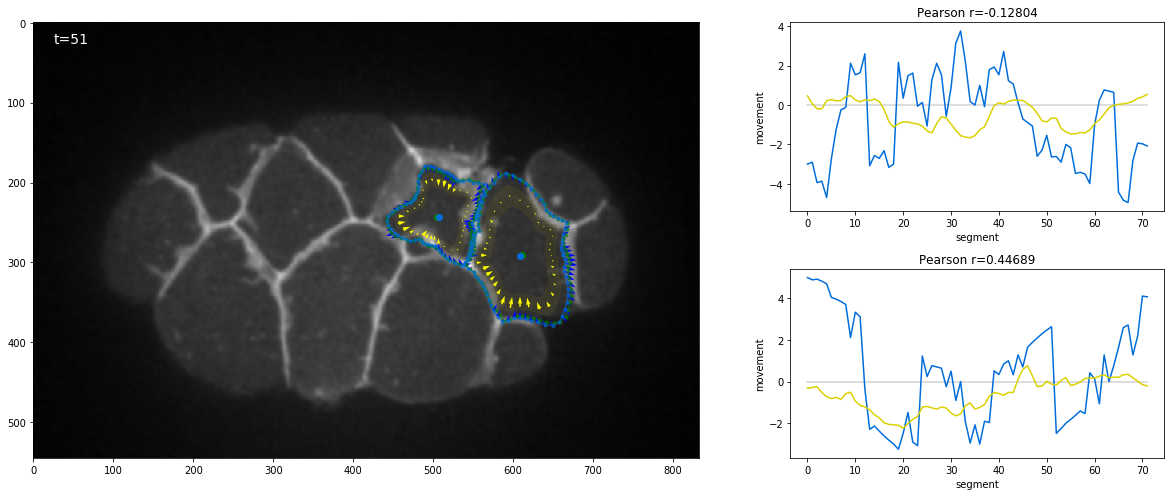

In [39]:
pylab.rcParams['figure.figsize'] = (17, 5)
fig = plt.figure()
ax = plt.subplot(121)
ax.set_title(data.object_names[0])
ax.set_xlabel('time')
ax.set_ylabel('movement / correlation')
ax.plot(np.zeros_like(correlation_per_frame_per_object[0]), color='lightgray')
ax.plot(correlation_per_frame_per_object[0], color='gray', label='pearson r')
ax.plot(avg_membrane_contraction_per_frame_per_object[0], color='#%02x%02x%02x'%(0,109,219), label='avg. mem')
ax.plot(avg_center_flow_per_frame_per_object[0], color='#%02x%02x%02x'%(219,209,0), label='avg. flow')
ax.legend( loc='lower right')
ax = plt.subplot(122)
ax.set_title(data.object_names[1])
ax.set_xlabel('time')
ax.set_ylabel('movement / correlation')
ax.plot(np.zeros_like(correlation_per_frame_per_object[1]), color='lightgray')
ax.plot(correlation_per_frame_per_object[1], color='gray', label='pearson r')
ax.plot(avg_membrane_contraction_per_frame_per_object[1], color='#%02x%02x%02x'%(0,109,219), label='avg. mem')
ax.plot(avg_center_flow_per_frame_per_object[1], color='#%02x%02x%02x'%(219,209,0), label='avg. flow')
ax.legend( loc='lower right')
fig.tight_layout()

pylab.rcParams['figure.figsize'] = (17, 7)
offset = 0
stepsize = 2
show_projected = True

for t in range(1,len(flowchannel),10):
    fig = plt.figure()
    ax = plt.subplot2grid((1, 3), (0, 0), colspan=2)
    ax2 = plt.subplot(233)
    ax3 = plt.subplot(236)

    ax.imshow(segchannel_smooth[t], plt.get_cmap('gray'))
    ax.text(25, 25, 't=%d'%t, fontsize=14, color='w')

    for obj in objects:
        # center points
        ax.plot(data.object_seedpoints[obj][t+1][0],data.object_seedpoints[obj][t+1][1], 'o', color='green')
        ax.plot(data.object_seedpoints[obj][t][0],data.object_seedpoints[obj][t][1], 'o', color='#%02x%02x%02x'%(0,109,219))
        
        # polygones (membrane and annulus)
        poly_membrane = geometry.Polygon(membrane_polygones_per_object[obj][t])
        poly_membrane_t2 = geometry.Polygon(membrane_polygones_per_object[obj][t+1])
        poly_annulus = geometry.Polygon(annulus_outer_polygones_per_object[obj][t], [annulus_inner_polygones_per_object[obj][t][::-1]])
        poly_annulus_middle = geometry.Polygon(annulus_middle_polygones_per_object[obj][t])

        plot_coords( ax, poly_membrane_t2.exterior, 'green', alpha=.5 )
        plot_coords( ax, poly_membrane.exterior, '#%02x%02x%02x'%(0,109,219) )

        patch_annulus = PolygonPatch(poly_annulus, facecolor='#%02x%02x%02x'%(219,209,0), edgecolor='orange', alpha=0.0625, zorder=2)
        ax.add_patch(patch_annulus)

        # membrane quivers
        mem_base_x = [p[0] for p in membrane_polygones_per_object[obj][t]]
        mem_base_y = [p[1] for p in membrane_polygones_per_object[obj][t]]
        if (show_projected):
            mem_vec = [column_vectors[i]*projected_mem_vecs_per_frame_per_object[obj][t][i] for i in range(len(column_vectors))]
            mem_vec_x = [v[0] for v in mem_vec]
            mem_vec_y = [-v[1] for v in mem_vec]
        else:
            mem_vec_x = [v[0] for v in membrane_movement_vectors_per_frame_per_object[obj][t]]
            mem_vec_y = [-v[1] for v in membrane_movement_vectors_per_frame_per_object[obj][t]]
        ax.quiver(mem_base_x, 
                  mem_base_y, 
                  mem_vec_x, 
                  mem_vec_y, 
                  width=0.0022, scale=flowchannel.shape[1]/2., color='blue')
        
        # flow quivers
        flow_base_x = [p[0] for p in annulus_middle_polygones_per_object[obj][t]]
        flow_base_y = [p[1] for p in annulus_middle_polygones_per_object[obj][t]]
        if (show_projected):
            flow_vec = [column_vectors[i]*projected_avg_flows_per_frame_per_object[obj][t][i] for i in range(len(column_vectors))]
            flow_vec_x = [v[0] for v in flow_vec]
            flow_vec_y = [-v[1] for v in flow_vec]
        else:
            flow_vec_x = [v[0] for v in annulus_avg_flow_vectors_per_frame_per_object[obj][t]]
            flow_vec_y = [-v[1] for v in annulus_avg_flow_vectors_per_frame_per_object[obj][t]]
        ax.quiver(flow_base_x[offset::stepsize], 
                  flow_base_y[offset::stepsize], 
                  flow_vec_x[offset::stepsize], 
                  flow_vec_y[offset::stepsize], 
                  pivot='mid', width=0.0022, scale=flowchannel.shape[1]/4., color='yellow')
        
    # LINEPLOT
    # ========
    ax2.set_title('Pearson r=%.5f'%correlation_per_frame_per_object[0][t])
    ax2.set_xlabel('segment')
    ax2.set_ylabel('movement')
    ax2.plot(np.zeros_like(projected_mem_vecs_per_frame_per_object[0][t]), color='lightgray')
    ax2.plot(projected_mem_vecs_per_frame_per_object[0][t], color='#%02x%02x%02x'%(0,109,219))
    ax2.plot(projected_avg_flows_per_frame_per_object[0][t], color='#%02x%02x%02x'%(219,209,0))

    ax3.set_title('Pearson r=%.5f'%correlation_per_frame_per_object[1][t])
    ax3.set_xlabel('segment')
    ax3.set_ylabel('movement')
    ax3.plot(np.zeros_like(projected_mem_vecs_per_frame_per_object[1][t]), color='lightgray')
    ax3.plot(projected_mem_vecs_per_frame_per_object[1][t], color='#%02x%02x%02x'%(0,109,219))
    ax3.plot(projected_avg_flows_per_frame_per_object[1][t], color='#%02x%02x%02x'%(219,209,0))

    fig.tight_layout()